### Systematic performance comparisons

Compare the following for recalibrating T5 cursor decoders:
- mean recalibration
- subspace realignment (optimized settings from `optimize_SubspaceRealignment.ipynb`)
- HMM (optimized settings from `optimize_vanillaHMM.ipynb`)

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from copy import deepcopy
import glob
import sys

[sys.path.append(f) for f in glob.glob('../utils/*')]
import preprocess, sweep_utils
from plotting_utils import figSize
from lineplots import plotsd
from session_utils import *
from recalibration_utils import *
from click_utils import *

import sweep_utils
import resample

fig_path    = '/home/users/ghwilson/projects/nonstationarities/figures/'

/share/software/user/open/py-scikit-learn/0.19.1_py36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [ ]:
# run for training set 

DATA_DIR = '/oak/stanford/groups/shenoy/ghwilson/nonstationarities/T5/'
methods  = ['HMM', 'Stabilizer', 'HMM-Stabilizer']
params   = [['kappa', 'inflection', 'exp'], 
            ['model', 'n_components', 'B', 'thresh'],
            ['kappa', 'inflection', 'exp']]


pearson_r_thresh = 0.15**0.5
dataset          = 'TRAIN'

scores = list()
fields = ['R2_score', 'pearson_r', 'days_apart', 'file', 'meanRecal_R2_score', 'meanRecal_pearson_r']
for m, p in zip(methods, params):
    
    if dataset == 'TRAIN':
        print('Loading training data.... \n')
        files = glob.glob(DATA_DIR + m + '/*/*scores_ID*')
        
        if m == 'HMM':
            prune = dict(zip(p, [2, 70, 0.5]))
        elif m == 'Stabilizer':
            prune = dict(zip(p, ['FactorAnalysis', 6, 160, 0.01]))
        elif m == 'HMM-Stabilizer':
            prune = dict(zip(p, [1, 0.1, 1.0]))
        else:
            raise ValueError('Method not recognized')
            
    elif dataset == 'TEST':
        print('Loading test data.... \n')
        files = glob.glob(DATA_DIR + m + '/test/*')
        prune = None
    
    else:
        raise ValueError('dataset must be TRAIN or TEST')
        

    scores_df = sweep_utils.getSummaryDataFrame(files, p + fields, prune = prune)
    #scores_df = scores_df[scores_df['meanRecal_pearson_r'] > pearson_r_thresh]
    scores_df = scores_df.sort_values(by = 'file', axis = 0).reset_index()
    scores.append(scores_df)

    #del scores_df  
    print(m, ' results loaded.')
    
    
assert [scores[i]['file'].equals(scores[i+1]['file']) for i in range(len(scores) - 1)], "Order mismatch"

Loading training data.... 

HMM  results loaded.
Loading training data.... 

Stabilizer  results loaded.
Loading training data.... 



In [ ]:
paired_scores = dict()
paired_scores['file']        = scores[0]['file']
paired_scores['timewindow']  = scores[0]['days_apart'] > 14
paired_scores['days_apart']  = scores[0]['days_apart']
paired_scores['meanrecal_pearson_r'] = scores[1]['meanRecal_pearson_r']
paired_scores['meanrecal_R2_score']  = scores[1]['meanRecal_R2_score']

# get scores for each approach
for method, score in zip(methods, scores):
    paired_scores[method + '_pearson_r'] = score['pearson_r']
    paired_scores[method + '_R2_score'] = score['R2_score']
    
# get score differences:
for method1, score1 in zip(methods, scores): 
    for method2, score2 in zip(methods, scores): 
        if method1 != method2:
            paired_scores[method1 + '_vs_' + method2] = score1['pearson_r'] - score2['pearson_r']

paired_scores = pd.DataFrame(paired_scores)

In [ ]:
paired_scores

75     0.709492
102    0.702462
Name: meanrecal_pearson_r, dtype: float64
6      0.444122
26     0.533682
43     0.442307
47     0.661579
56     0.594651
62     0.661072
71     0.692536
83     0.645018
89     0.708051
92     0.626973
109    0.521262
Name: meanrecal_pearson_r, dtype: float64
66     0.706418
72     0.662910
106    0.587314
118    0.622238
Name: meanrecal_pearson_r, dtype: float64
39     0.601730
57     0.586623
79     0.698372
103    0.560542
116    0.511238
Name: meanrecal_pearson_r, dtype: float64
21     0.568794
36     0.560853
45     0.432798
50     0.469656
63     0.626186
67     0.699844
76     0.699977
86     0.605980
91     0.641568
107    0.447013
Name: meanrecal_pearson_r, dtype: float64
40     0.522998
68     0.682281
80     0.659090
104    0.636660
Name: meanrecal_pearson_r, dtype: float64
4      0.472597
9      0.529195
22     0.443308
32     0.423035
37     0.491575
48     0.511324
51     0.604115
58     0.552107
64     0.554713
73     0.634569
77     0.661

Name: HMM-Stabilizer_pearson_r, dtype: float64
11     0.689248
14     0.630475
31     0.712315
115         NaN
121         NaN
Name: HMM-Stabilizer_pearson_r, dtype: float64
96   NaN
Name: HMM-Stabilizer_pearson_r, dtype: float64
8      0.691512
123         NaN
126         NaN
Name: HMM-Stabilizer_pearson_r, dtype: float64


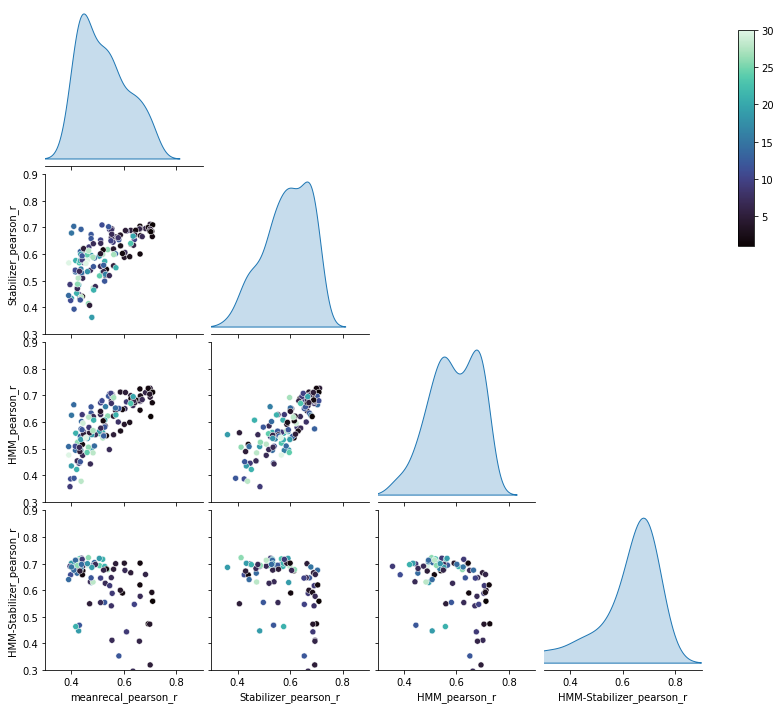

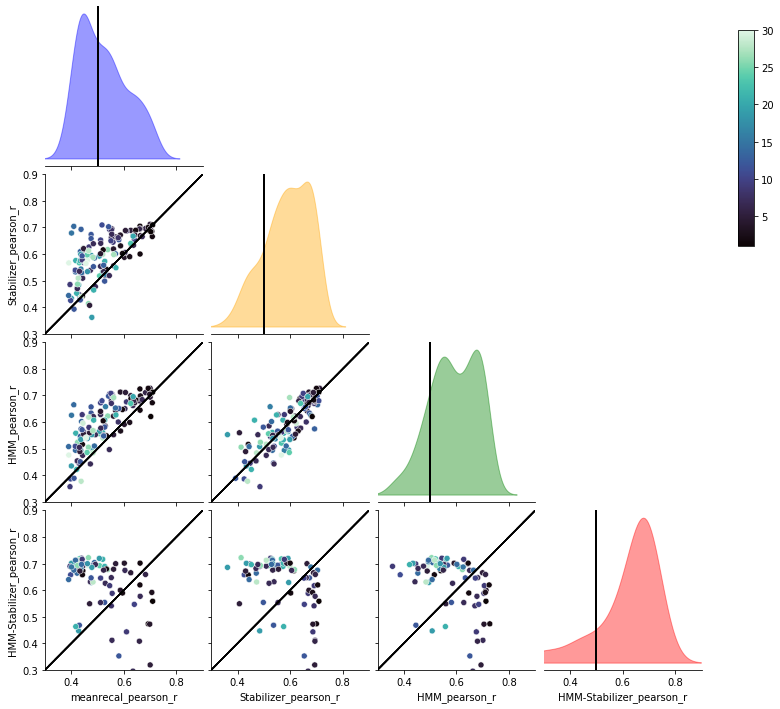

In [62]:
#figSize(10, 20)

figSize(5, 5)

metric = 'pearson_r'
lims   = [0.3, 0.9]



fields = [x + metric for x in ['meanrecal_', 'Stabilizer_', 'HMM_', 'HMM-Stabilizer_']]

pp = sns.pairplot(paired_scores, vars = fields, 
                  hue = 'days_apart', corner = True, palette = "mako", 
                  diag_kws = {'hue' : None})
pp.set(xlim = lims)
pp.set(ylim = lims)

pp.legend.remove()
cax    = pp.fig.add_axes([.95, .65, .02, .3])
points = plt.scatter([], [], c= [], vmin = paired_scores['days_apart'].min(), 
                     vmax = paired_scores['days_apart'].max(), cmap = 'mako')
pp.fig.colorbar(points , cax = cax, )

def addUnity(xdata, ydata, **kwargs):
    ax = plt.gca()
    ax.plot(lims, lims, color = 'k', alpha = 0.2)
    
def addMedian(xdata, **kwargs):
    ax = plt.gca()
    print(xdata)
    ax.axvline(0.5, color = 'k', )
    
pp.map_offdiag(addUnity)
pp.map_diag(addMedian)
colors = ['b', 'orange', 'g', 'r']
for i, ax in enumerate(pp.diag_axes):
    col = ax.collections[0]
    col.set_color(colors[i])
    col.set_alpha(0.4)
    
#plt.savefig(fig_path + f'/comparisons/{dataset}_comparisons', format = 'pdf')
plt.show()


In [43]:
deltas    = list()
windows   = 7
max_ndays = 28

deltas = dict()


methods = ['meanrecal', 'Stabilizer', 'HMM', 'HMM-Stabilizer']

for i in range(0, max_ndays, windows):
    week        = int(i / windows)
    graph, idxs = resample.makeSessionPairGraph(paired_scores, lims = [i, i + windows])
    subset      = idxs[resample.graphSets(graph)]
    subset_df   = paired_scores.iloc[subset]

    deltas[week] = dict()
    for method1 in methods:
        for method2 in methods:
            if method1 != method2:
                query1 = method1 + '_pearson_r'
                query2 = method2 + '_pearson_r'
                key    = method1 + '_' + method2 
                deltas[week][key]  = subset_df[query1] - subset_df[query2]
    
    print(week + 1, '/', int(max_ndays / windows))

#sns.stripplot(data = deltas)
#plt.xlabel('Weeks apart')
#plt.ylabel('Delta($r_HMM - r_Stab$)')
#plt.show()

1 / 4
2 / 4
3 / 4
4 / 4


In [46]:
subset_df

,file,timewindow,days_apart,meanrecal_pearson_r,meanrecal_R2_score,HMM_pearson_r,HMM_R2_score,Stabilizer_pearson_r,Stabilizer_R2_score,HMM-Stabilizer_pearson_r,HMM-Stabilizer_R2_score,Delta
12,/oak/stanford/groups/shenoy/ghwilson/nonstatio...,True,21,0.519523,0.263492,0.561037,0.286489,0.532293,0.271163,0.716064,0.511983,0.028744
16,/oak/stanford/groups/shenoy/ghwilson/nonstatio...,True,24,0.507673,0.231337,0.556079,0.177260,0.517825,0.255523,0.691974,0.478501,0.038254
20,/oak/stanford/groups/shenoy/ghwilson/nonstatio...,True,23,0.430712,0.183950,0.520767,0.268664,0.566883,0.320793,0.717448,0.514483,-0.046116


In [81]:
import re

def getConsecutivePairs(scores_df):
    
    pat          = '\d\d\d\d\.\d\d\.\d\d'
    unique_dates = np.unique(np.concatenate([re.findall(pat, x) for x in scores_df['file'] ]))
    
    unique_pairs = [(unique_dates[i], unique_dates[i+1]) for i in range(len(unique_dates) - 1)]
    
    idxs = list()
    for pair in unique_pairs:
        idx_a = np.where([pair[0] in x for x in scores_df['file']])
        idx_b = np.where([pair[1] in x for x in scores_df['file']])
        idx   = np.intersect1d(idx_a, idx_b)[0]
        idxs.append(idx)
        
    return idxs

In [83]:
getConsecutivePairs(scores[0])

IndexError: index 0 is out of bounds for axis 0 with size 0

In [355]:
fields

['meanrecal_pearson_r',
 'Stabilizer_pearson_r',
 'HMM_pearson_r',
 'HMM-Stabilizer_pearson_r']

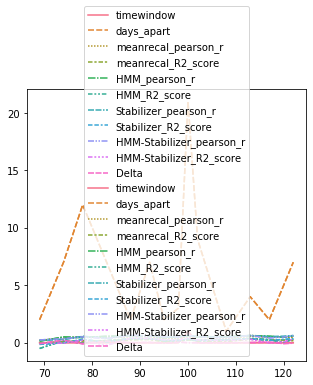

In [328]:
sns.lineplot(data= paired_scores.iloc[x],)
plt.show()

In [329]:
paired_scores.iloc[x]

,file,timewindow,days_apart,meanrecal_pearson_r,meanrecal_R2_score,HMM_pearson_r,HMM_R2_score,Stabilizer_pearson_r,Stabilizer_R2_score,HMM-Stabilizer_pearson_r,HMM-Stabilizer_R2_score,Delta
69,/oak/stanford/groups/shenoy/ghwilson/nonstatio...,False,2,0.198376,-0.039111,0.130170,-0.502479,0.217995,-0.148990,0.236587,-0.065519,-0.087825
74,/oak/stanford/groups/shenoy/ghwilson/nonstatio...,False,7,0.408017,0.080478,0.496125,0.167751,0.281693,-0.013652,0.358559,-0.036292,0.214431
78,/oak/stanford/groups/shenoy/ghwilson/nonstatio...,False,12,0.483767,0.154998,0.444308,-0.051147,0.547047,0.287999,0.499678,0.220662,-0.102739
83,/oak/stanford/groups/shenoy/ghwilson/nonstatio...,False,7,0.463057,0.175179,0.558982,0.191138,0.417486,0.041888,0.359113,-0.230378,0.141496
88,/oak/stanford/groups/shenoy/ghwilson/nonstatio...,False,2,0.520041,0.257586,0.598113,0.328854,0.609965,0.370366,0.630335,0.393942,-0.011851
92,/oak/stanford/groups/shenoy/ghwilson/nonstatio...,False,7,0.541183,0.283564,0.616622,0.358916,0.596513,0.353086,0.604063,0.364167,0.020109
95,/oak/stanford/groups/shenoy/ghwilson/nonstatio...,False,2,0.346098,0.088494,0.428798,0.123912,0.481684,0.211658,0.504930,0.252209,-0.052886
98,/oak/stanford/groups/shenoy/ghwilson/nonstatio...,False,3,0.416193,0.117001,0.503637,0.221738,0.459837,0.147324,0.492778,0.240857,0.043800
100,/oak/stanford/groups/shenoy/ghwilson/nonstatio...,True,21,0.513023,0.260636,0.604229,0.258863,0.605761,0.352553,0.644000,0.399151,-0.001531
102,/oak/stanford/groups/shenoy/ghwilson/nonstatio...,False,9,0.483886,0.158525,0.510152,0.231436,0.519021,0.156439,0.503840,0.243871,-0.008869


In [315]:
np.where([pair[1] in x for x in scores[0]['file']])

(array([38, 43, 47, 50, 52, 53]),)

### check out badly performing days:

In [78]:
bad_days = scores[1]['R2_score'] - scores[0]['R2_score'] > 0.2
bad_days = scores[0]['file'][bad_days]

print([x.split('_to_')[1].split('.npy')[0] for x in bad_days])

['2021.05.17', '2021.07.19', '2021.07.19', '2021.07.19', '2021.07.19']


In [79]:
print([x.split('_to_')[0].split('/test/')[1] for x in bad_days])

['2021.05.05', '2021.06.28', '2021.07.07', '2021.07.12', '2021.07.14']


In [16]:
files = glob.glob('/oak/stanford/groups/shenoy/gwilson/nonstationarities/T5/new/*')

bad_idx = np.where(['2021.07.19' in x for x in files])[0]

In [20]:
files[bad_idx[0]]

'/oak/stanford/groups/shenoy/gwilson/nonstationarities/T5/new/t5.2021.07.19.mat'

In [17]:

dayA = DataStruct(files[bad_idx[0]], causal_filter= 2)

# Fit day A decoders: 
Atrain_x, Atest_x, Atrain_y, Atest_y = getTrainTest(dayA, train_size = 0.67, task = None, returnFlattened = True)
Atrain_x, Atest_x  = get_BlockwiseMeanSubtracted(Atrain_x, Atest_x, concatenate = True)

#thresh   = np.percentile(train_x, 99) * 2 
#test_x[np.abs(test_x) > thresh] = thresh * np.sign(test_x[np.abs(test_x) > thresh])


/share/software/user/open/py-scikit-learn/0.19.1_py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


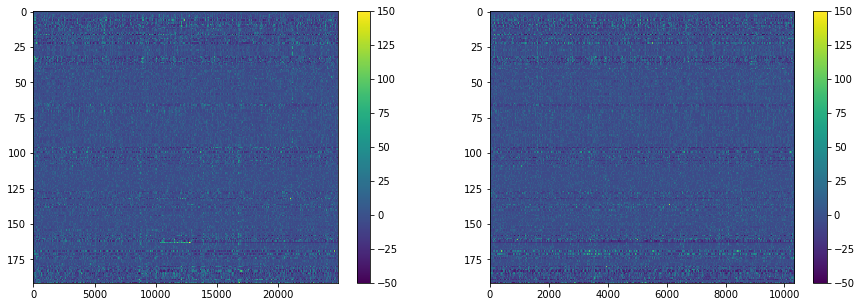

In [18]:
figSize(5, 15)

plt.subplot(1, 2, 1)
plt.imshow(Atrain_x.T, aspect = 'auto')
#plt.title(files[bad_idx[0]])
plt.clim(-50, 150)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(Atest_x.T, aspect = 'auto')
#plt.title(files[bad_idx[0]])
plt.clim(-50, 150)
plt.colorbar()
plt.show()


In [158]:
dayA = DataStruct('/oak/stanford/groups/shenoy/gwilson/nonstationarities/T5/new/t5.2021.07.14.mat', causal_filter = 2)
dayB = DataStruct('/oak/stanford/groups/shenoy/gwilson/nonstationarities/T5/new/t5.2021.07.19.mat', causal_filter = 2)

In [159]:
figSize(15, 15)


FR_diffs = np.zeros((2, 192))
# Fit day A decoders: 
Atrain_x, Atest_x, Atrain_y, Atest_y = getTrainTest(dayA, train_size = 0.67, task = None, returnFlattened = True)
Btrain_x, Btest_x, Btrain_y, Btest_y, cursorPos, _ = getTrainTest(dayB, train_size = 0.67, task = None, returnFlattened = True, returnCursor = True)

FR_diffs[0, :] = np.concatenate(Atrain_x).mean(axis = 0)
FR_diffs[1, :] = np.concatenate(Btrain_x).mean(axis = 0)

Atrain_x, Atest_x  = get_BlockwiseMeanSubtracted(Atrain_x, Atest_x, concatenate = True)
Btrain_x, Btest_x  = get_BlockwiseMeanSubtracted(Btrain_x, Btest_x, concatenate = True)

lm_a              = LinearRegression(fit_intercept = False).fit(Atrain_x, np.concatenate(Atrain_y))
preds             = lm_a.predict(Btest_x )

decoder_preds = [np.concatenate(Btest_y), preds]


/share/software/user/open/py-scikit-learn/0.19.1_py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


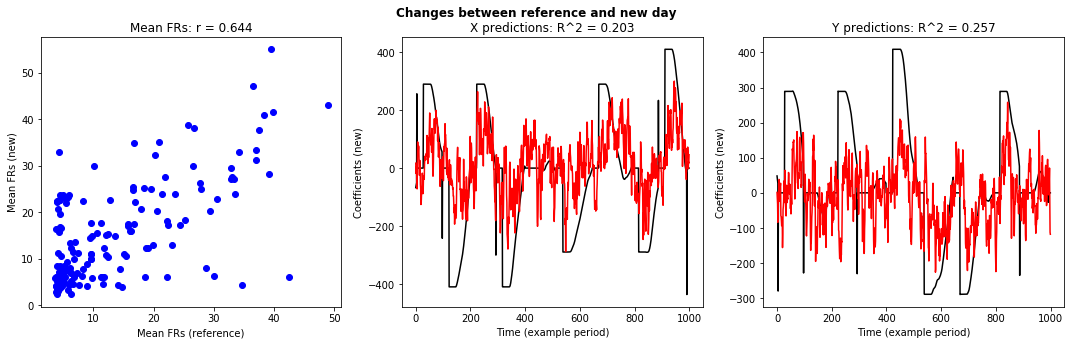

In [160]:
from sklearn.metrics import r2_score
from scipy.stats import spearmanr

subplt_size = 5
plt_days    = 1

#----------------------------------
figSize(5, 15)

coord_type = ['X', 'Y']
plt.subplot(1, 3, 1 + (j * 3))
x    = FR_diffs[0, :]
y    = FR_diffs[1, :]
corr = spearmanr(x, y)[0] 

plt.scatter(x, y, color = 'b')
#maxval = max(x.max(), y.max())
#plt.xlim([0, maxval + 10])
#plt.ylim([0, maxval + 10])
plt.xlabel('Mean FRs (reference)')
plt.ylabel('Mean FRs (new)')
#plt.plot(plt.xlim(), plt.xlim(), linestyle = '--', color = 'k')
plt.title('Mean FRs: r = ' + str(np.round(corr, 3)))

for coord in range(2):
    x    = decoder_preds[0][:, coord]
    y    = decoder_preds[1][:, coord]
    corr = r2_score(x, y)
    #corr = np.corrcoef(x, y)[0, 1]

    plt.subplot(1, 3, coord + 2 + (j * 3))
    plt.plot(x[4000:5000], color = 'k')
    plt.plot(y[4000:5000], color = 'r')

    maxval = max(x.max(), y.max())
    minval = min(x.min(), y.min())
    #plt.xlim([minval, maxval ])
    #plt.ylim([minval, maxval ])
    plt.xlabel('Time (example period)')
    plt.ylabel('Coefficients (new)')
    plt.title(coord_type[coord] + ' predictions: R^2 = ' + str(np.round(corr, 3)))

plt.suptitle('Changes between reference and new day', fontweight = 'bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


In [161]:
preds             = recal_decoder.predict(Btest_x)

decoder_preds = [np.concatenate(Btest_y), preds]

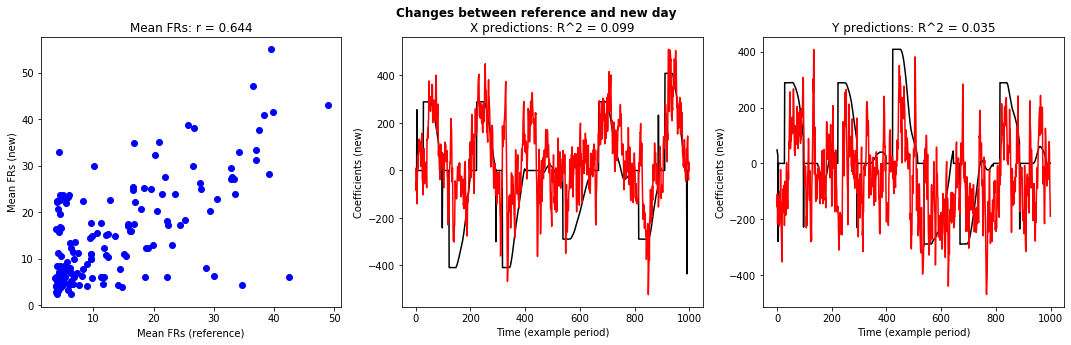

In [162]:
from sklearn.metrics import r2_score
from scipy.stats import spearmanr

subplt_size = 5
plt_days    = 1

#----------------------------------
figSize(5, 15)

coord_type = ['X', 'Y']
plt.subplot(1, 3, 1 + (j * 3))
x    = FR_diffs[0, :]
y    = FR_diffs[1, :]
corr = spearmanr(x, y)[0] 

plt.scatter(x, y, color = 'b')
#maxval = max(x.max(), y.max())
#plt.xlim([0, maxval + 10])
#plt.ylim([0, maxval + 10])
plt.xlabel('Mean FRs (reference)')
plt.ylabel('Mean FRs (new)')
#plt.plot(plt.xlim(), plt.xlim(), linestyle = '--', color = 'k')
plt.title('Mean FRs: r = ' + str(np.round(corr, 3)))

for coord in range(2):
    x    = decoder_preds[0][:, coord]
    y    = decoder_preds[1][:, coord]
    corr = r2_score(x, y)
    #corr = np.corrcoef(x, y)[0, 1]

    plt.subplot(1, 3, coord + 2 + (j * 3))
    plt.plot(x[4000:5000], color = 'k')
    plt.plot(y[4000:5000], color = 'r')

    maxval = max(x.max(), y.max())
    minval = min(x.min(), y.min())
    #plt.xlim([minval, maxval ])
    #plt.ylim([minval, maxval ])
    plt.xlabel('Time (example period)')
    plt.ylabel('Coefficients (new)')
    plt.title(coord_type[coord] + ' predictions: R^2 = ' + str(np.round(corr, 3)))

plt.suptitle('Changes between reference and new day', fontweight = 'bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


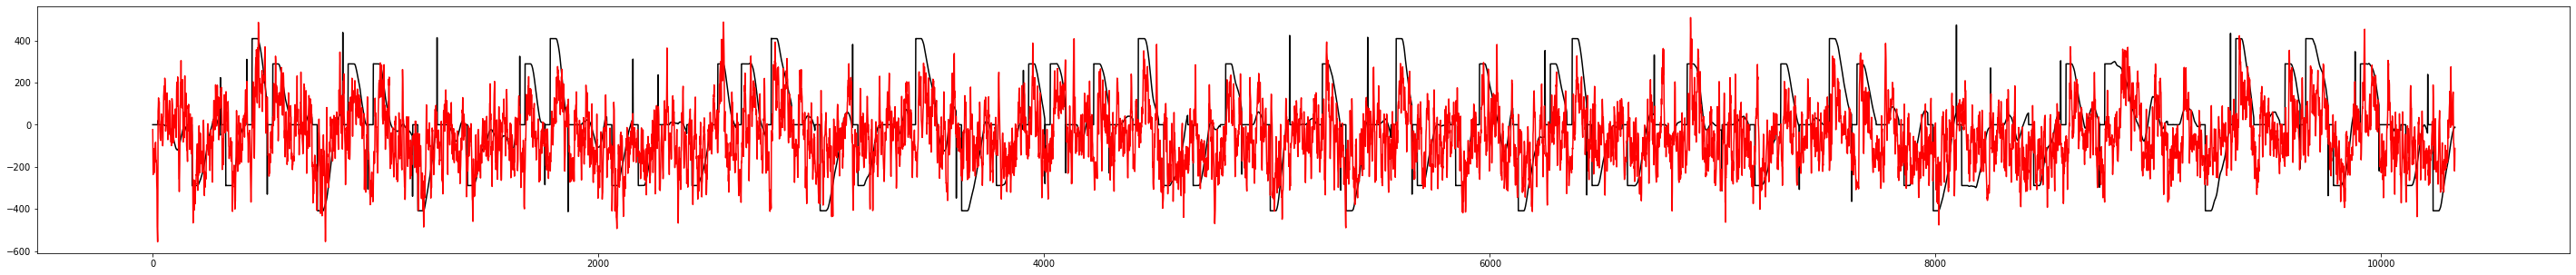

In [157]:
figSize(5, 50)
plt.plot(x[:], color = 'k')
plt.plot(y[:], color = 'r')
plt.show()

### test running continuously (offline)

In [125]:
min_nblocks = 3       # min number of blocks for a session to be include
max_ndays   = 30      # accept all pairs of sessions regardless of time between
sigma       = 2       # causal gaussian smoothing for TXs
task        = None    # subselect any tasks
train_size  = 0.67    # fraction of blocks for training data
gridSize    = 20      

data_dir    = '/oak/stanford/groups/shenoy/gwilson/nonstationarities/'
participant = 'T5/new/'
save_path   = '/oak/stanford/groups/shenoy/gwilson/nonstationarities/T5/test/'


# load data:
files       = loadDataset(data_dir, participant)

# preprocess by selecting sessions with a minimal block count:
sessions_check = np.load('../utils/misc_data/NewSessions_check.npy', allow_pickle = True).item()
files          = get_Sessions(files, min_nblocks, manually_remove = None)


In [148]:
ref_session = DataStruct(files[1], alignScreens = True, causal_filter = sigma)
    

# obtain features and cursorError targets:
Atrain_x, Atest_x, Atrain_y, Atest_y  = getTrainTest(ref_session, train_size = train_size, blocks = None, task = task, returnFlattened = True)    
Atrain_x, Atest_x  = get_BlockwiseMeanSubtracted(Atrain_x, Atest_x, concatenate = True)
Atrain_y           = np.concatenate(Atrain_y)
Atest_y            = np.concatenate(Atest_y)

ref_decoder = LinearRegression(fit_intercept = False, normalize = False).fit(Atrain_x, Atrain_y)
print('Reference day R^2: ', ref_decoder.score(Atest_x, Atest_y))

Reference day R^2:  0.25546189702129396


/share/software/user/open/py-scikit-learn/0.19.1_py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [149]:
from hmm_utils import get_DiscreteTargetGrid
from hmm import HMMRecalibration


# HMM setup:
gridSize      = 20  
stayProb      = 0.999
vmKappa       = 2
inflection    = 50
exp           = 0.1
probThreshold = 'probWeighted'

#-----------------------------------------

nStates         = gridSize**2
stateTrans      = np.eye(nStates)*stayProb #Define the state transition matrix, which assumes uniform transition probability of transitioning to new state
targLocs        = get_DiscreteTargetGrid(ref_session, gridSize = gridSize, task = task)

for x in range(nStates):
    idx                = np.setdiff1d(np.arange(nStates), x)
    stateTrans[x, idx] = (1-stayProb)/(nStates-1)
    
pStateStart = np.zeros((nStates,1)) + (1/nStates)
adjustKappa = lambda dist : 1 / (1 + np.exp(-1 * (dist - inflection) * exp))


In [150]:
date          = [ref_session.date]
models        = list()
scores        = np.zeros((5, len(files) - 1)) # rows are 0 - no recalibration; 1 - mean recalibration; 2 - full recalibration; 3 - HMM recalibration (initial); 4 - HMM recalibration (each session)
scores[:, 0]  = ref_decoder.score(Atest_x, Atest_y)

hmm_new_ref = deepcopy(ref_decoder)
for i, file in enumerate(files[2:]):
    new_dat     = DataStruct(file, alignScreens = True, causal_filter = sigma)
    date.append(new_dat.date)
    
    train_x, test_x, train_y, test_y, cursorPos, _  = getTrainTest(new_dat, train_size = train_size, sigma = sigma, task = task, blocks = None, 
                                                               returnFlattened = True, returnCursor = True)
    
    train_x, test_x_MeanRecal = get_BlockwiseMeanSubtracted(train_x, test_x, concatenate = True)
    
    test_x          = np.concatenate(test_x)
    train_y         = np.concatenate(train_y)
    test_y          = np.concatenate(test_y)
    cursorPos       = np.concatenate(cursorPos)

    scores[0, i + 1] = ref_decoder.score(test_x, test_y)                                                         # no recalibration
    scores[1, i + 1] = ref_decoder.score(test_x_MeanRecal, test_y)                                               # mean recalibration
    scores[2, i + 1] = LinearRegression(normalize = False).fit(train_x, train_y).score(test_x_MeanRecal, test_y) # full recalibration
    
    targLocs = get_DiscreteTargetGrid(new_dat, gridSize = gridSize, task = task)
    hmm      = HMMRecalibration(stateTrans, targLocs, pStateStart, vmKappa, adjustKappa)

    hmm_init_ref     = hmm.recalibrate(deepcopy(ref_decoder), [train_x], [cursorPos], probThreshold = probThreshold)
    hmm_new_ref      = hmm.recalibrate(hmm_new_ref, [train_x], [cursorPos], probThreshold = probThreshold)
    scores[3, i + 1] = hmm_init_ref.score(test_x_MeanRecal, test_y)
    scores[4, i + 1] = hmm_new_ref.score(test_x_MeanRecal, test_y)
   
    print(new_dat.date, ' finished')

/share/software/user/open/py-scikit-learn/0.19.1_py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


2021.05.05  finished
2021.05.17  finished
2021.05.24  finished
2021.05.26  finished
2021.06.02  finished
2021.06.04  finished
2021.06.07  finished
2021.06.28  finished
2021.07.07  finished
2021.07.08  finished
2021.07.12  finished
2021.07.14  finished
2021.07.19  finished
2021.07.26  finished


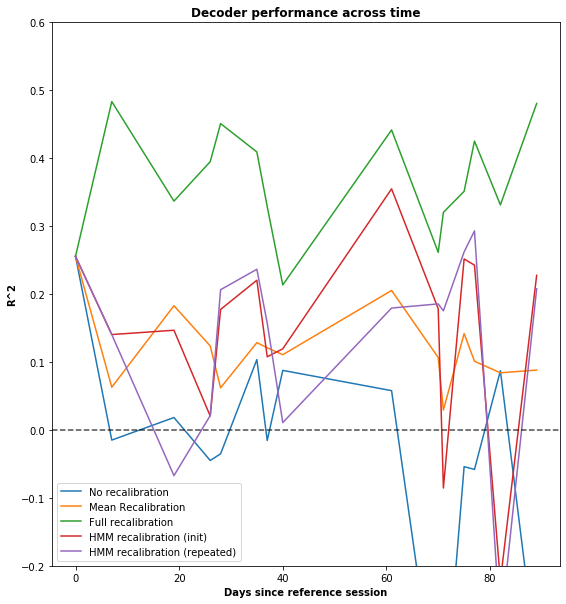

In [154]:
from preprocess import daysBetween
days = [daysBetween(ref_session.date, date[i]) for i in range(len(date))]


figSize(10, 20)

plt.subplot(1, 2, 1)
labels = ['No recalibration', 'Mean Recalibration', 'Full recalibration', 'HMM recalibration (init)', 'HMM recalibration (repeated)']
for i in range(5):
    plt.plot(days[:], scores[i, :].T, label = labels[i])

plt.ylim([-0.2, 0.6]) 
plt.xlabel('Days since reference session', fontweight = 'bold')
plt.ylabel('R^2', fontweight = 'bold')
plt.axhline(0, color = 'k', linestyle = '--', alpha  = 0.7)
plt.title('Decoder performance across time', fontweight = 'bold')
plt.legend()
plt.show()

In [153]:
len(days)

15

In [ ]:
from sklearn.linear_model import TheilSenRegressor
from resample import bootstrap_LinearRegression
figSize(10, 20)


plt_days = np.where(diffs < 4)[0]

#-----------------------------------
FR_changes = np.abs(np.mean(FR_diffs[1, :, :] - FR_diffs[0, :, :], axis = 0))
FR_corr    = [spearmanr(FR_diffs[1, :, i], FR_diffs[0, :, i])[0] for i in range(len(files) - 1) ]

plt.subplot(1, 2, 1)
plt.scatter(FR_changes, dayB_HMMscores[opt_D, opt_B, :])
#plt.scatter(FR_changes, dayB_HMMscores[opt_D, opt_B, :] / dayB_scores[opt_D, opt_B, :])

for i in plt_days:
    plt.scatter(FR_changes[i], dayB_HMMscores[opt_D, opt_B, i], color = 'r')
plt.ylim([-1, 1])
plt.xlabel('Mean FR difference')
plt.ylabel('Recalibration performance (R^2)')
plt.title('HMM performance vs. mean FR difference', fontweight = 'bold')

# bootstrap linear regression:
lm, means, coefs = bootstrap_LinearRegression(FR_changes[:, np.newaxis], dayB_HMMscores[opt_D, opt_B, :], regressor = TheilSenRegressor(), n_bootstraps= 500, random_state= 42)

for i in range(500):
    plt.plot(FR_changes, means[i, :] + np.multiply(FR_changes, coefs[i, :]), alpha = 0.01, color = 'b')
plt.plot(FR_changes, lm.predict(FR_changes[:, np.newaxis]), alpha = 1, color = 'b')
    
    
plt.subplot(1, 2, 2)
decoder_R2 = np.asarray([r2_score(decoder_preds[i][0], decoder_preds[i][1]) for i in range(len(files) - 1)])

plt.scatter(decoder_R2, dayB_HMMscores[opt_D, opt_B, :])
for i in plt_days:
    plt.scatter(decoder_R2[i], dayB_HMMscores[opt_D, opt_B, i], color = 'r')
plt.ylim([-1, 1])
plt.xlim([-1, 1])
plt.xlabel('Reference decoder performance on new day (R^2)')
plt.ylabel('Recalibration performance (R^2)')
plt.title('HMM performance vs. non-recalibrated decoder performance', fontweight = 'bold')

lm, means, coefs = bootstrap_LinearRegression(decoder_R2[:, np.newaxis], dayB_HMMscores[opt_D, opt_B, :], regressor = TheilSenRegressor(), n_bootstraps= 500, random_state= 42)

#for i in range(500):
#    plt.plot(dplt.xlim(), means[i, :] + np.multiply(np.asarray(plt.xlim()), coefs[i, :]), alpha = 0.01, color = 'b')
plt.plot(plt.xlim(), lm.predict(np.asarray(plt.xlim())[:, np.newaxis]), alpha = 1, color = 'b')

In [ ]:
bad_days

In [ ]:
for i in bad_days:
    print(DataStruct(files[i]).date, '  ', DataStruct(files[i+1]).date )

    